* Librispeach clean (train 360h, test, dev)
* Common voice en (2 681h validated, train, test, dev)

In [1]:
import tarfile
import os

extract_dir = "data/extracted/"

for archive in os.listdir("data"):
    if archive.endswith(".gz"):
        archive = f"data/{archive}"
        try:
            with tarfile.open(archive, "r:gz") as tar:
                tar.extractall(path=extract_dir)
                print(f"{archive} extracted to: {extract_dir}")
        
        except Exception as e:
            print(f"Error: {e} extracting {archive}")

data/cv-corpus-20.0-2024-12-06-en.tar.gz extracted to: data/extracted/
data/test-clean.tar.gz extracted to: data/extracted/
data/train-clean-360.tar.gz extracted to: data/extracted/
data/dev-clean.tar.gz extracted to: data/extracted/


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re
import h5py
from typing import Union, Optional, List
import unicodedata

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

pd.options.display.float_format = '{:.2f}'.format

audio_files_dir = "data/extracted/cv-corpus-20.0-2024-12-06/en/clips/"
char_to_num = {char: idx + 1 for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz ")}
char_to_num['<PAD>'] = 0
n_mfcc = 13

In [166]:
def clean_transcription(text: str):
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r'[^\w\s]', "", text)
    return text.lower()


def make_data_df(dataset: str, threshold: Optional[Union[int, float]] = None):

    df = pd.read_csv(f"data/extracted/cv-corpus-20.0-2024-12-06/en/{dataset}.tsv",
                               sep='\t',
                               usecols=["sentence", "path"])
    
    df["clean_sentence"] = df.sentence.apply(clean_transcription)
    df = df[df['clean_sentence'].apply(lambda x: bool(re.match("^[a-z ]+$", x)))].reset_index(drop=True)
    df["num_characters"] = df.clean_sentence.map(len)

    threshold = threshold if threshold else df.num_characters.quantile(0.99)
    idxs = np.where(df.num_characters > threshold)[0].tolist()
    df.drop(idxs, inplace=True)

    return df, threshold


def get_features_and_label(audio_filename: str, raw_label: str):
    
    audio_file_path = f'{audio_files_dir}{audio_filename}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)
    
    # mfcc extraction
    mfcc = librosa.feature.mfcc(y=audio_time_series, sr=sample_rate, n_mfcc=n_mfcc)
    
    # label
    label = np.array([char_to_num.get(char, 28) for char in raw_label], dtype="uint8")

    return mfcc, label
    

def get_data(info_df: pd.DataFrame, n_samples: int = None, data_frac: float = None):

    X = []
    y = []

    df = info_df.sample(n=n_samples, frac=data_frac, random_state=42)

    for sample in df.itertuples():
        mfcc, label = get_features_and_label(sample.path, sample.clean_sentence)
        X.append(mfcc)
        y.append(label)

    return X, y, df

# CommonVoice

In [137]:
train_labels = pd.read_csv("data/extracted/cv-corpus-20.0-2024-12-06/en/train.tsv",
                           sep='\t',
                           usecols=["sentence", "path"])

train_labels["clean_sentence"] = train_labels.sentence.apply(clean_transcription)
train_labels["num_characters"] = train_labels.clean_sentence.map(len)
    
train_labels.head()

,path,sentence,clean_sentence,num_characters
0,common_voice_en_26405174.mp3,"There were coupe, sedan, and station wagon mod...",there were coupe sedan and station wagon model...,57
1,common_voice_en_26405176.mp3,His descendants and ideas would dominate class...,his descendants and ideas would dominate class...,91
2,common_voice_en_26405179.mp3,Or was it?,or was it,9
3,common_voice_en_649608.mp3,It’s just a few blocks to the North.,its just a few blocks to the north,34
4,common_voice_en_649610.mp3,I was never so tired in my life.,i was never so tired in my life,31


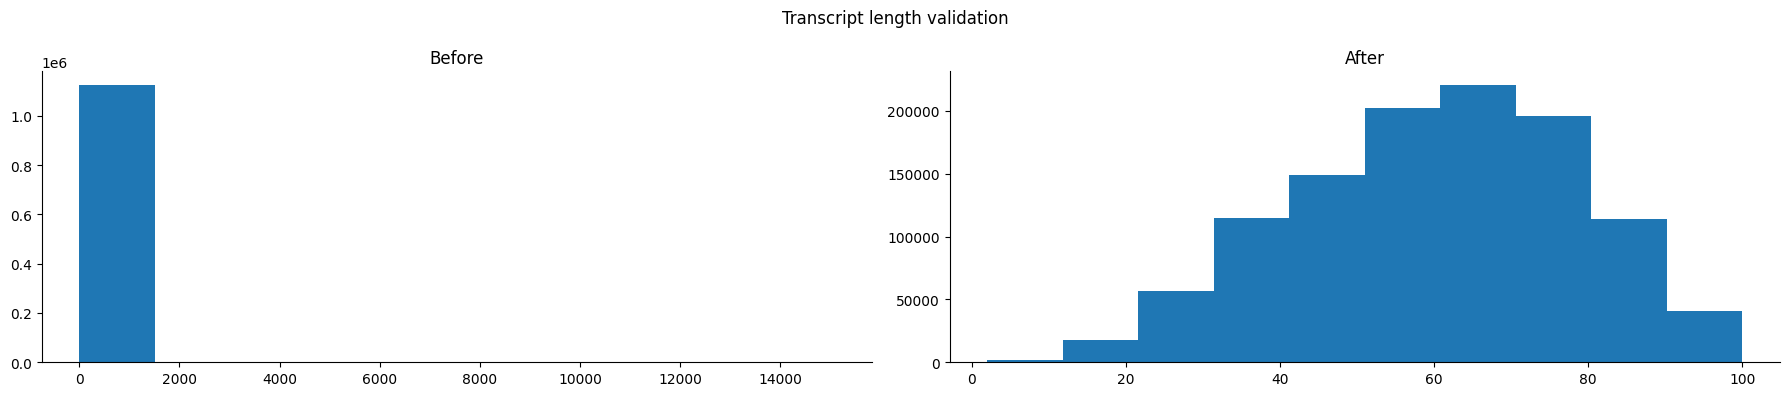

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plt.suptitle("Transcript length validation")
ax[0].hist(train_labels.num_characters)
ax[0].set_title("Before")

threshold = train_labels.num_characters.quantile(0.99)
idxs = np.where(train_labels.num_characters > threshold)[0].tolist()
train_labels.drop(idxs, inplace=True)

ax[1].hist(train_labels.num_characters)
ax[1].set_title("After")
plt.tight_layout();

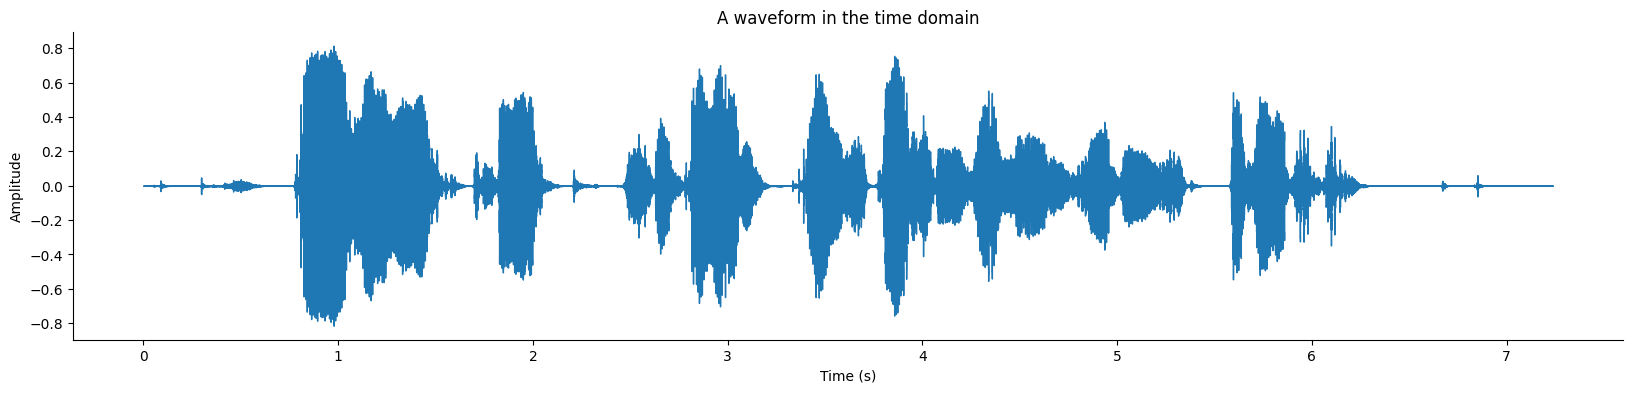

MFCC size: (13, 227)


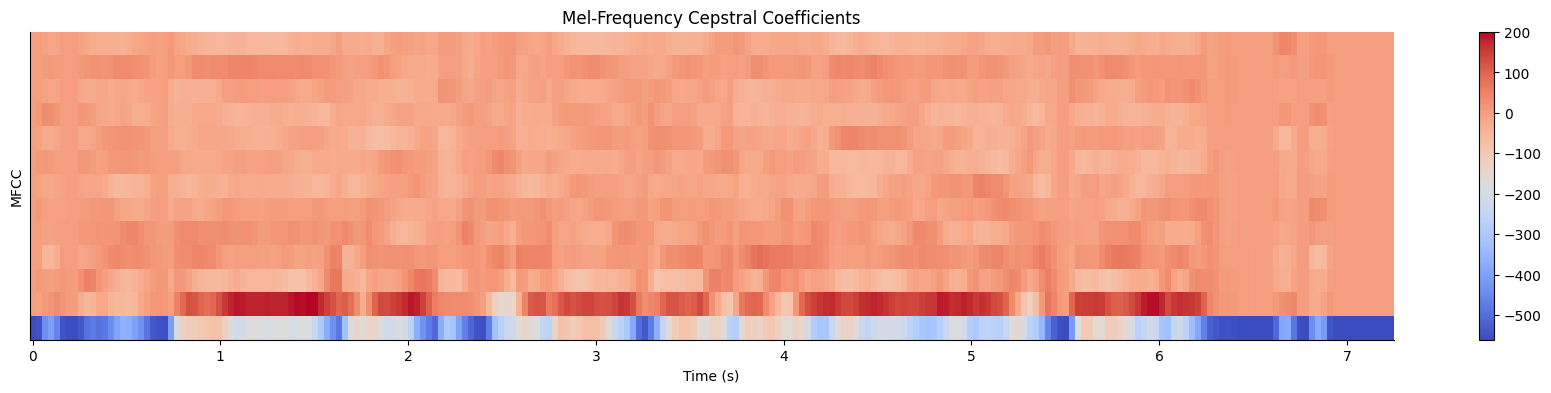

Label:
there were coupe sedan and station wagon models available
Encoded label:
[20  8  5 18  5 27 23  5 18  5 27  3 15 21 16  5 27 19  5  4  1 14 27  1
 14  4 27 19 20  1 20  9 15 14 27 23  1  7 15 14 27 13 15  4  5 12 19 27
  1 22  1  9 12  1  2 12  5] 



In [136]:
for sample in train_labels[:1].itertuples():

    # data
    audio_file_path = f'{audio_files_dir}{sample.path}'
    audio_time_series, sample_rate = librosa.load(audio_file_path, sr=16000)

    plt.figure(figsize=(20, 4))
    librosa.display.waveshow(audio_time_series, sr=sample_rate)
    plt.title("A waveform in the time domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # mfcc extraction
    mfcc, transcript = get_features_and_label(sample.path, sample.clean_sentence)
    print(f"MFCC size: {mfcc.shape}")
    
    plt.figure(figsize=(22, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title("Mel-Frequency Cepstral Coefficients")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC")
    plt.show()
    
    print("Label:")
    print(sample.clean_sentence)
    print("Encoded label:")
    print(transcript, "\n")

# Dataset

In [140]:
# loading data at once without unvalid too long transcriptions
# truncation threshold set to quantile 0.99 in train dataset, i.e. 100 characters

train_df, threshold = make_data_df("train")
test_df, _ = make_data_df("test", threshold=threshold)
val_df, _ = make_data_df("dev", threshold=threshold)
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 1113636
Test size: 16279
Validation size: 16253


Jako dane treningowe używamy wstępnie 75k losowych próbek. Chcemy sprawdzić, jaka będzie wielkość tablic dla współczynników mfcc dla różnych próbek, aby pozbyć się próbek o skrajnych wartościach, a także wyliczyć statystyki do standaryzacji danych.

In [141]:
X_train, _, sample_df = get_data(train_df, n_samples=75000)

In [142]:
for sample in X_train[:5]:
    print(sample.shape)

(13, 170)
(13, 229)
(13, 211)
(13, 197)
(13, 127)


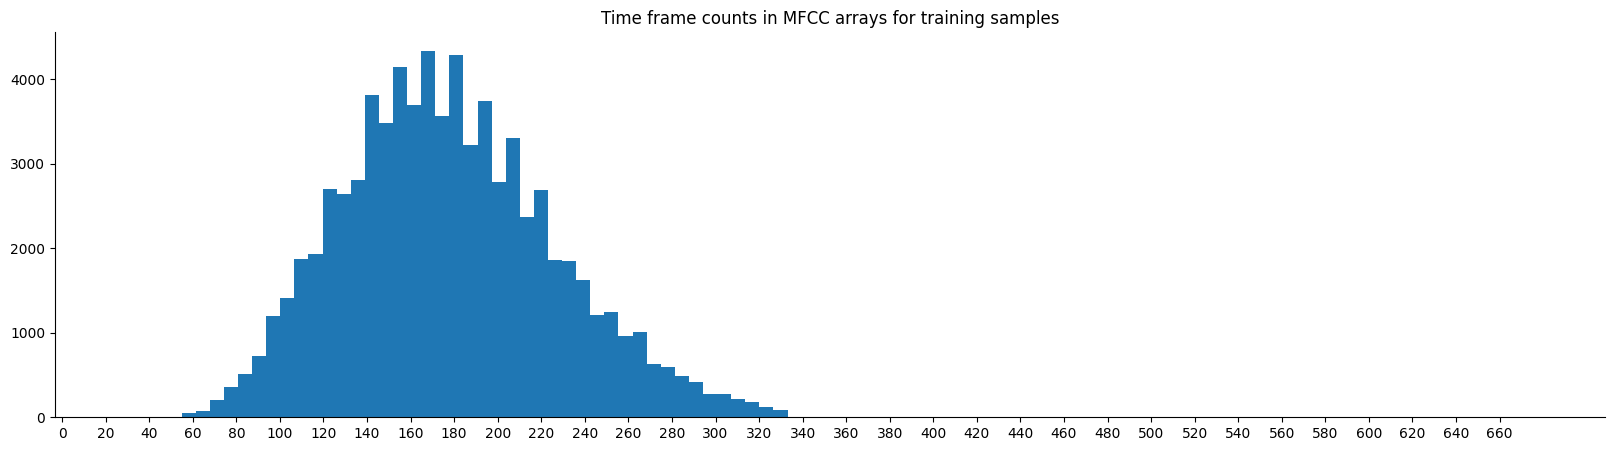

In [143]:
sample_df["n_time_steps"] = [sample.shape[1] for sample in X_train]

plt.figure(figsize=(20, 5))
plt.hist(sample_df.n_time_steps, bins=100)
ticks = np.arange(0, sample_df.n_time_steps.max(), 20)
plt.xticks(ticks)
plt.title("Time frame counts in MFCC arrays for training samples");

In [145]:
condition = (sample_df.n_time_steps <= 320) & (sample_df.n_time_steps >= 70)
final_train_df = sample_df[condition]
final_train_df

,path,sentence,clean_sentence,num_characters,n_time_steps
592644,common_voice_en_23597288.mp3,The Supreme Court refused to hear the city's a...,the supreme court refused to hear the citys ap...,69,170
14990,common_voice_en_19646443.mp3,She based Olive's nasal vocal quality and expr...,she based olives nasal vocal quality and expre...,59,229
426143,common_voice_en_23936130.mp3,Why ask for trouble and cause your own downfal...,why ask for trouble and cause your own downfal...,70,211
900938,common_voice_en_19536785.mp3,"He also considered Marco Ruas as ""nothing spec...",he also considered marco ruas as nothing speci...,58,197
393891,common_voice_en_79549.mp3,A brown and white dog running on grass.,a brown and white dog running on grass,38,127
...,...,...,...,...,...
223877,common_voice_en_19595232.mp3,The bill and feet are slate grey.,the bill and feet are slate grey,32,103
851992,common_voice_en_23801254.mp3,Mazar began her career as a hip hop b-girl in ...,mazar began her career as a hip hop bgirl in n...,58,175
14989,common_voice_en_19646441.mp3,"Some of the boyars flee; some join the battle,...",some of the boyars flee some join the battle o...,70,223
560174,common_voice_en_23627775.mp3,The Cumans practiced Shamanism and Tengrism.,the cumans practiced shamanism and tengrism,43,238


In [154]:
filtered_X_train = [X_train[i] for i in range(len(X_train)) if condition.iloc[i]]
mel_coefs = np.concatenate(filtered_X_train, axis=1)

means = np.mean(mel_coefs, axis=1)
stdts = np.std(mel_coefs, axis=1)

with h5py.File('data/CommonVoice/train_stats_75k.h5', 'w') as file:
    file.create_dataset('means', data=means)
    file.create_dataset('stds', data=stdts)
    
pd.DataFrame({"means": means,"stds": stds})

,means,stds
0,-338.26,163.20
1,79.73,70.95
2,3.66,41.03
3,21.43,35.67
4,-4.82,26.70
5,-3.46,22.04
6,-11.83,21.21
7,-6.07,18.11
8,-8.60,16.64
9,-3.97,14.40


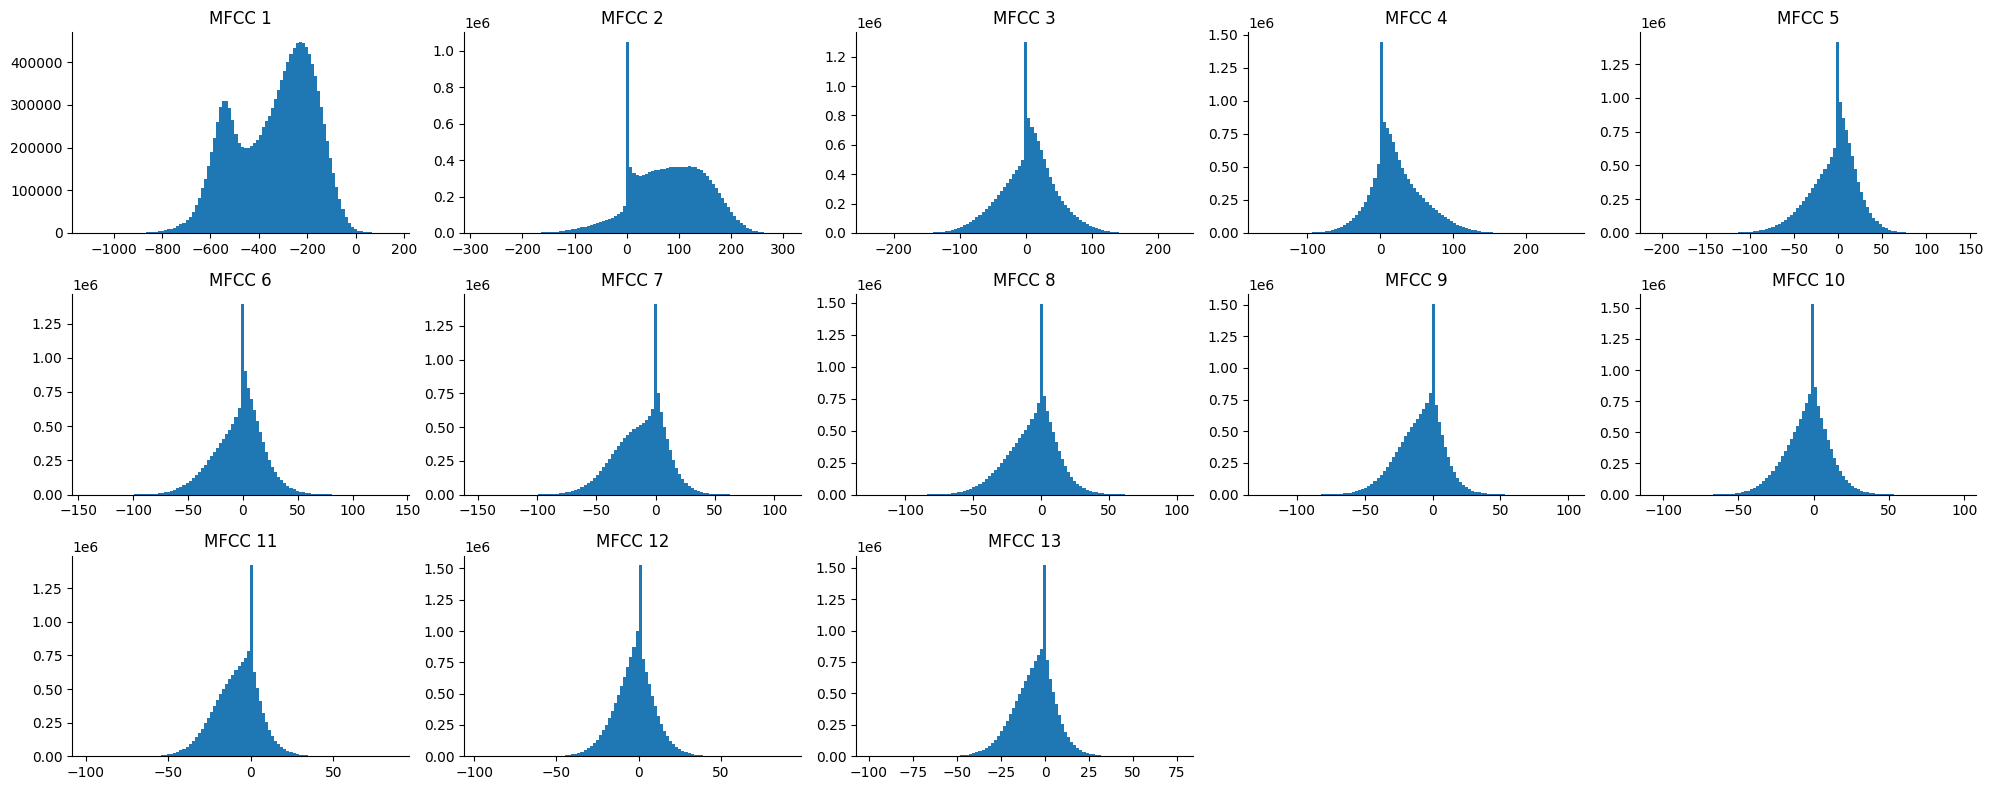

In [326]:
fig, axes = plt.subplots(3, 5, figsize=(20, 8))

axes = axes.flatten()

for i in range(n_mfcc):
    axes[i].hist(mel_coefs[i], bins=100)
    axes[i].set_title(f"MFCC {i+1}")
for i in range(n_mfcc, len(axes)):
    axes[i].set_axis_off()
plt.tight_layout();

# Saving prepared dataset

In [329]:
with h5py.File("data/CommonVoice/train_stats_75k.h5", "r") as hf:
    means = hf["means"][:]
    stds = hf["stds"][:]

In [332]:
def save_data(df, save_path, mean, std, save_condition=lambda x: 70 <= x <= 320):
    
    means = tf.reshape(mean, [1, n_mfcc])
    stds = tf.reshape(std, [1, n_mfcc])

    with h5py.File(save_path, "w") as hf:
        mfcc_group = hf.create_group("mfcc")
        labels_group = hf.create_group("labels")
        
        i = 0
        for sample in df.itertuples():
            mfcc, label = get_features_and_label(sample.path, sample.clean_sentence)
    
            if save_condition(mfcc.shape[1]):
                mfcc = (mfcc.T - means) / stds
                mfcc_group.create_dataset(str(i), data=mfcc, compression="gzip")
                labels_group.create_dataset(str(i), data=label, compression="gzip")
                i += 1

    print(f"Saved: {save_path} with {i} samples.")

save_data(final_train_df, "data/CommonVoice/train_data_75k.h5", means, stds)
save_data(test_df, "data/CommonVoice/test_data.h5", means, stds)
save_data(val_df, "data/CommonVoice/val_data.h5", means, stds)

Saved: data/CommonVoice/train_data_75k.h5 with 74577 samples.
Saved: data/CommonVoice/test_data.h5 with 15897 samples.
Saved: data/CommonVoice/val_data.h5 with 15994 samples.


In [328]:
with h5py.File("data/CommonVoice/train_data_75k.h5", "r") as hf:
    data = hf["mfcc"]
    for i, (key, sample) in enumerate(data.items()):
        if i < 1:
            print(key, sample)
            print(sample[:].shape)
            print(sample[:])

0 <HDF5 dataset "0": shape (170, 13), type "<f4">
(170, 13)
[[-1.2524942  -0.9653059   0.15992025 ...  0.45811158 -0.08094042
   0.08570684]
 [-0.9815859  -0.38940516  0.32598755 ...  0.21926682 -0.5976857
  -0.2982167 ]
 [-0.7633846  -0.0013947   0.4483624  ...  0.50201416 -0.2503381
  -0.06016012]
 ...
 [-1.1443295  -0.65919685  0.5709095  ...  0.07012546 -0.4692591
  -0.08549494]
 [-1.1506857  -0.7062879   0.4823349  ...  0.11918257 -0.544741
  -0.05849064]
 [-1.1742544  -0.77135307  0.4336124  ...  0.19928145 -0.5559967
  -0.07902121]]
